# Cluster analysis of seasonal and diurnal precipitation

## General info about K means algorithm

- input: K (nr of clusters) and data in form of 2D array)
- calculate Euclidean distance to centroids of data  
- updating centroid by calculating means of all data points which are assigned to one specific centroid's cluster

## Notes 

- GPM data: seasonal= 'GPM_IMERG_cluster_input_seasonal.nc4' , diurnal: 'GPM_IMERG_cluster_input_diurnal.nc4'
- best nr of classes for seasonal seems to be 8 
- always 2D input maxtrix: n x features (monthly contribution to annual precip, hourly contribution to daily precip)

# To do 
 

- PCA of seasonality
- cluster analysis for diurnal cycles
- visualization for cluster analysis (cbar)
- compare results from PCA and cluster analysis

In [23]:
from sklearn import cluster
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans


import os
import glob 
import random 

import matplotlib.pyplot as plt
import cartopy
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors

import scipy
from scipy import ndimage
from scipy.stats import skew
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt

from netCDF4 import Dataset
from collections import Counter 

from numpy import genfromtxt

import pandas as pd 


In [80]:
# read in dataset on which the cluster analysis will be performed 
def read_in_netcdf(file):
    dataset = Dataset(file)    
    precip= np.array(dataset["precipitationCal"])
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    dataset.close()
    return precip, lon, lat


In [84]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_cluster_input_seasonal.nc4'
precip, lon, lat = read_in_netcdf(file)

In [109]:
#convert 3D matrix to 2D input matrix with n_gridpoints x n_features
data= np.reshape(precip, (12,351*181))
data= data.transpose()
np.shape(data)

(63531, 12)

In [200]:
X = data # input matrix shape (n_samples, n_features)
k = 8
kmeans = KMeans(n_clusters= k, random_state=0).fit(X)

# attributes
centers = kmeans.cluster_centers_ # n_clusters x n_features
labels = kmeans.labels_ # contains the actual classes 
cluster_grid= np.reshape(kmeans.labels_, ((351,181)))


np.shape(kmeans.cluster_centers_)
#np.shape(kmeans.labels_)

(8, 12)

## Plots

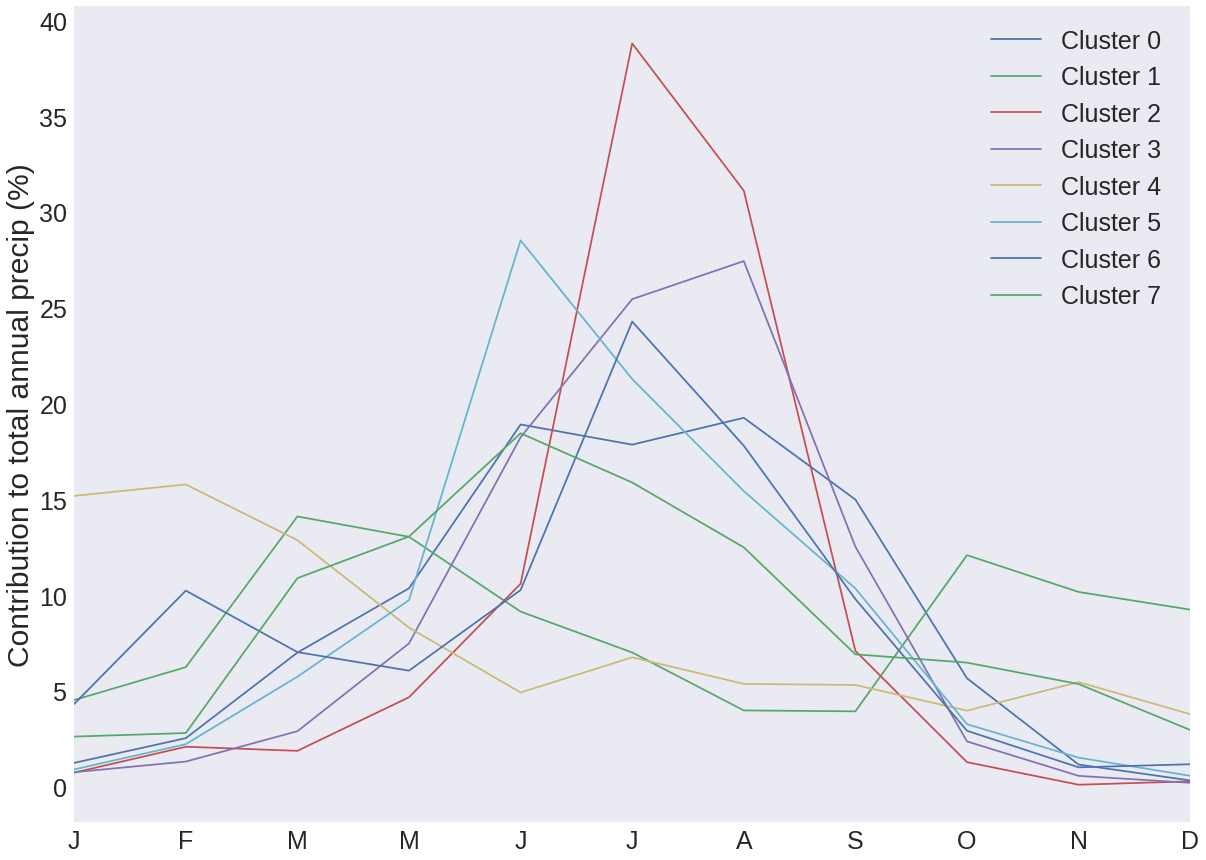

In [203]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(20, 15))
plt.ylabel('Contribution to total annual precip (%)', fontsize= 30)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.grid()
plt.xlim(1,11)
plt.plot(kmeans.cluster_centers_[0], label= 'Cluster 0 ')
plt.plot(kmeans.cluster_centers_[1], label= 'Cluster 1 ')
plt.plot(kmeans.cluster_centers_[2], label= 'Cluster 2 ')
plt.plot(kmeans.cluster_centers_[3], label= 'Cluster 3 ')
plt.plot(kmeans.cluster_centers_[4], label= 'Cluster 4 ')
plt.plot(kmeans.cluster_centers_[5], label= 'Cluster 5 ')
plt.plot(kmeans.cluster_centers_[6], label= 'Cluster 6 ')
plt.plot(kmeans.cluster_centers_[7], label= 'Cluster 7 ')
         
         
plt.legend( prop={'size': 25})
#plt.show()
plt.rcParams.update({'font.size': 30})


plt.savefig('/media/juli/Elements/comparison/gpm_seasonal_cluster8.pdf')

In [72]:
np.shape(cluster_grid.T)

(181, 351)

In [77]:
# fast plot

#plt.imshow(cluster_grid)

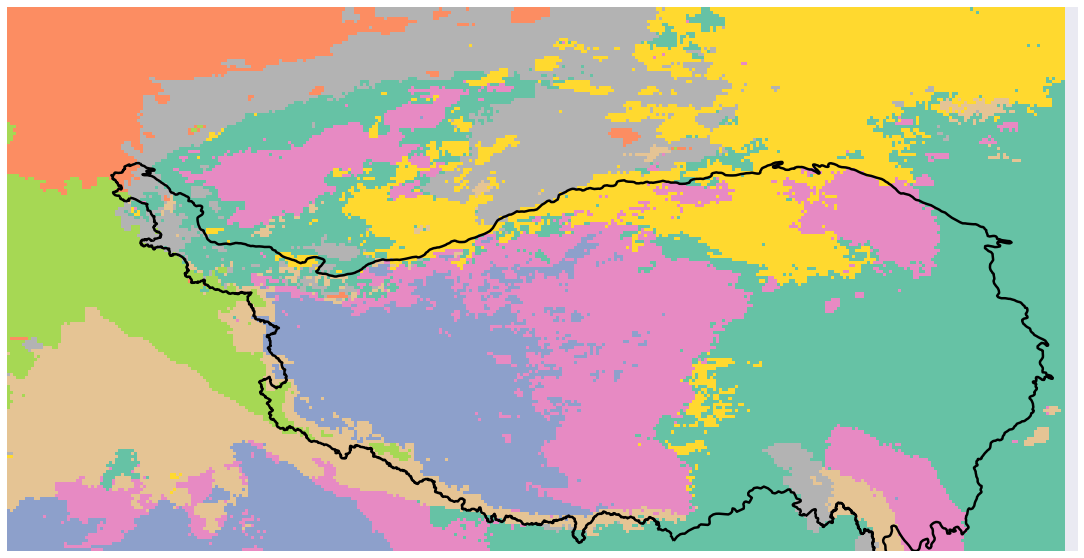

In [204]:
plt.figure(figsize=(20, 10))


cmap = plt.cm.get_cmap('Set2')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.5,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
cs = m.pcolormesh(xi,yi, cluster_grid.T, cmap = cmap) 


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)

plt.savefig('/media/juli/Elements/comparison/cluster_seasonal_grid8.png')

## Getting optimal k (number of clusters) with elbow method

- mean distance of all data points to their centroid as a function of k 
- this will always decrease, but find elbow point

In [175]:
dis = np.array(())

for l in np.unique(labels):
    selected_rows = data[labels == l,:]
    for col in np.arange(0,12):
        m = np.absolute(np.subtract(selected_rows[:,col],centers[l,col]))
        dis = np.append(dis,m, axis = 0)

In [176]:
mean_distance = np.nanmean(dis)
mean_distance

2.3438313514551603

In [198]:
# test different k
k_variations = [1, 2,3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15, 16, 17]
distances = [] 

for k in k_variations:
    print('calculating... mean distances to centroid for K = ', k)
    kmeans = KMeans(n_clusters= k, random_state=0).fit(X)
    centers = kmeans.cluster_centers_ 
    labels = kmeans.labels_
    dis = np.array(())

    for l in np.unique(labels):
        selected_rows = data[labels == l,:]
        for col in np.arange(0,12):
            m = np.absolute(np.subtract(selected_rows[:,col],centers[l,col]))
            dis = np.append(dis,m, axis = 0)
        mean = np.nanmean(dis)
    mean_distance = np.nanmean(mean)
    distances.append(mean_distance)

calculating... mean distances to centroid for K =  1
calculating... mean distances to centroid for K =  2
calculating... mean distances to centroid for K =  3
calculating... mean distances to centroid for K =  4
calculating... mean distances to centroid for K =  5
calculating... mean distances to centroid for K =  6
calculating... mean distances to centroid for K =  7
calculating... mean distances to centroid for K =  8
calculating... mean distances to centroid for K =  9
calculating... mean distances to centroid for K =  10
calculating... mean distances to centroid for K =  11
calculating... mean distances to centroid for K =  12
calculating... mean distances to centroid for K =  13
calculating... mean distances to centroid for K =  14
calculating... mean distances to centroid for K =  15
calculating... mean distances to centroid for K =  16
calculating... mean distances to centroid for K =  17


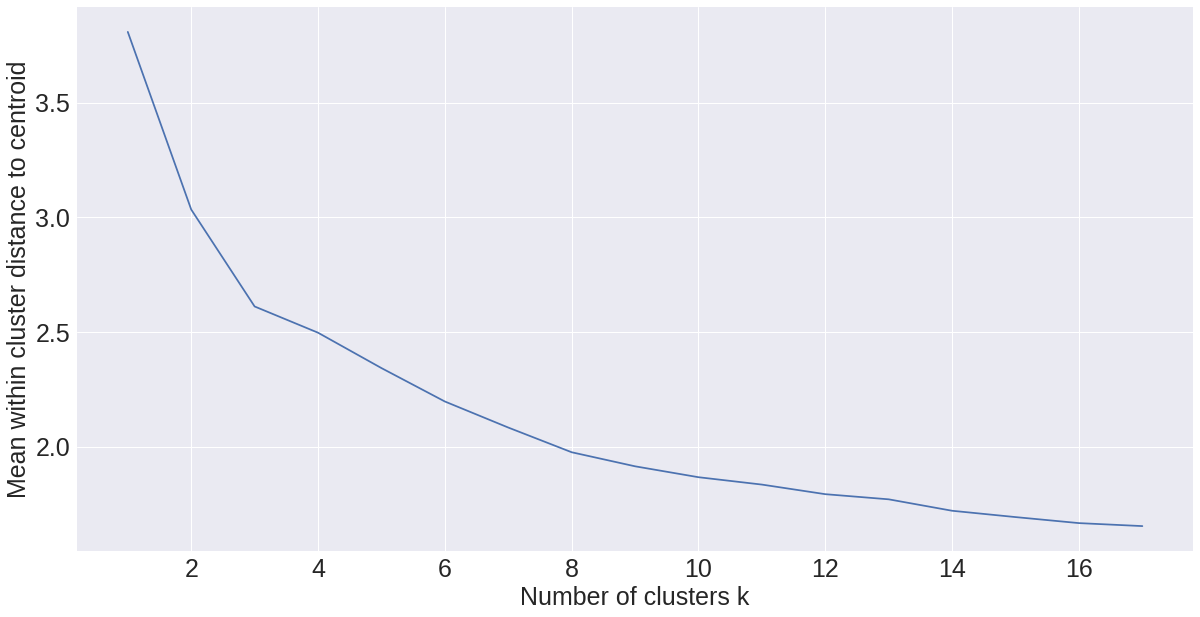

In [199]:
plt.figure(figsize=(20, 10))
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})

plt.plot(k_variations, distances)
plt.xlabel('Number of clusters k', fontsize = 25)
plt.ylabel('Mean within cluster distance to centroid', fontsize = 25)
plt.show()

# PCA of seasonal precip over the TP 